# Load Imports

In [3]:
import os
import numpy as np
import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import random
import matplotlib.pyplot as plt

# Load Dataset

In [4]:
# Define the directories for the dataset
train_dir = "/kaggle/input/cardetection/car/train"  # images, labels (bounding boxes)

# Preprocessing (Images and Annoations)

In [3]:
# Function to load and normalize images and bounding boxes
def load_images_and_bboxes(img_dir, label_dir, img_size=(224, 224)):
    images = []
    bboxes = []

    for filename in os.listdir(img_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            # Load image
            img_path = os.path.join(img_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)  # Resize to uniform size
            img = img.astype('float32') / 255.0  # Normalize image to [0, 1]
            images.append(img)

            # Load label (bounding box) if present
            label_path = os.path.join(label_dir, filename.replace('.jpg', '.txt').replace('.png', '.txt'))
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    label = f.read().strip().split()  # Assuming [class, x_min, y_min, x_max, y_max]
                    if len(label) >= 5:
                        # Extract bounding box: [x_min, y_min, x_max, y_max]
                        bbox = [float(val) for val in label[1:5]]  # Skip the class value
                        bboxes.append(bbox)
                    else:
                        bboxes.append([0, 0, 0, 0])  # Default placeholder if label is malformed
            else:
                bboxes.append([0, 0, 0, 0])  # Placeholder for non-annotated images

    return np.array(images), np.array(bboxes)


# Load the data
X, y = load_images_and_bboxes(os.path.join(train_dir, 'images'), os.path.join(train_dir, 'labels'))

In [4]:
X[0]

array([[[0.32156864, 0.33333334, 0.34901962],
        [0.32156864, 0.33333334, 0.34901962],
        [0.32156864, 0.33333334, 0.34901962],
        ...,
        [0.8666667 , 0.70980394, 0.7529412 ],
        [0.85882354, 0.70980394, 0.75686276],
        [0.85882354, 0.70980394, 0.75686276]],

       [[0.32156864, 0.33333334, 0.34901962],
        [0.32156864, 0.33333334, 0.34901962],
        [0.32156864, 0.33333334, 0.34901962],
        ...,
        [0.8666667 , 0.70980394, 0.7529412 ],
        [0.85882354, 0.70980394, 0.75686276],
        [0.85882354, 0.70980394, 0.75686276]],

       [[0.32156864, 0.3372549 , 0.34117648],
        [0.32156864, 0.3372549 , 0.34117648],
        [0.32156864, 0.3372549 , 0.34117648],
        ...,
        [0.8666667 , 0.70980394, 0.7529412 ],
        [0.85882354, 0.70980394, 0.75686276],
        [0.85882354, 0.70980394, 0.75686276]],

       ...,

       [[0.10196079, 0.09019608, 0.09803922],
        [0.10196079, 0.09019608, 0.09803922],
        [0.10196079, 0

In [5]:
y

array([[0.53846154, 0.49879808, 0.53846154, 0.58052885],
       [0.41586538, 0.22355769, 0.30889423, 0.22596154],
       [0.52043269, 0.49158654, 0.70673077, 0.70192308],
       ...,
       [0.52884615, 0.50961538, 0.59975962, 0.58413462],
       [0.49519231, 0.14663462, 0.15264423, 0.07692308],
       [0.53605769, 0.54086538, 0.625     , 0.74759615]])

# Visualization

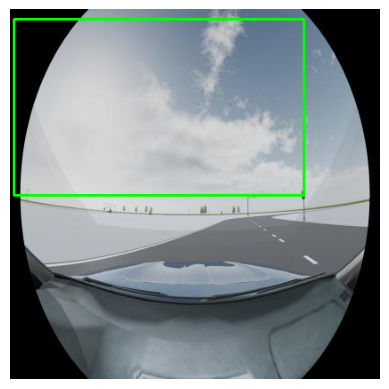

In [10]:
# Function to display a random image with its corresponding bounding box
def display_random_image_with_bbox(images, bboxes):
    # Choose a random index
    random_index = random.randint(0, len(images) - 1)
    
    # Get image and corresponding bounding box
    img = images[random_index]
    bbox = bboxes[random_index]

    # Convert from BGR to RGB for plotting
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert bbox coordinates back to pixel values (relative to image size)
    img_height, img_width = img.shape[:2]
    x_min, y_min, x_max, y_max = bbox
    x_min = int(x_min * img_width)
    y_min = int(y_min * img_height)
    x_max = int(x_max * img_width)
    y_max = int(y_max * img_height)

    # Draw the bounding box
    image_with_bbox = cv2.rectangle(image_rgb, 
                                    (x_min, y_min), 
                                    (x_max, y_max), 
                                    (0, 255, 0), 2)  # Green bounding box

    # Display the image
    plt.imshow(image_with_bbox)
    plt.axis('off')  # Hide axis
    plt.show()

# Example: Display a random image from training set with bounding box
display_random_image_with_bbox(X, y)


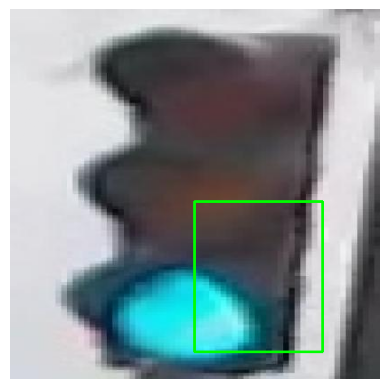

In [11]:
# Example: Display a random image from training set with bounding box
display_random_image_with_bbox(X, y)

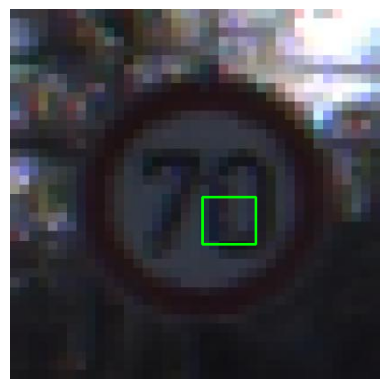

In [12]:
# Example: Display a random image from training set with bounding box
display_random_image_with_bbox(X, y)

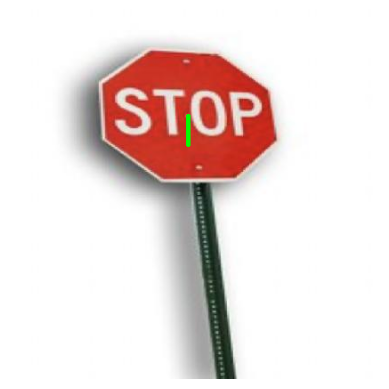

In [13]:
# Example: Display a random image from training set with bounding box
display_random_image_with_bbox(X, y)

# Train Test Split

In [14]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training

In [15]:
# Build the CNN model using transfer learning (ResNet50 as an example)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Create the custom head for the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(4, activation='sigmoid')  # 4 outputs for bbox coordinates
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error', metrics=['accuracy'])

# Train the model using the training data
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - accuracy: 0.3193 - loss: 0.0519 - val_accuracy: 0.3796 - val_loss: 0.0367
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 181ms/step - accuracy: 0.3895 - loss: 0.0377 - val_accuracy: 0.3952 - val_loss: 0.0322
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 181ms/step - accuracy: 0.4492 - loss: 0.0329 - val_accuracy: 0.5864 - val_loss: 0.0255
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 181ms/step - accuracy: 0.4998 - loss: 0.0269 - val_accuracy: 0.5694 - val_loss: 0.0223
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 181ms/step - accuracy: 0.5120 - loss: 0.0249 - val_accuracy: 0.6105 - val_loss: 0.0208
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 181ms/step - accuracy: 0.5224 - loss: 0.0229 - val_accuracy: 0.6076 - val_loss: 0.0188
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 181ms/step - accuracy: 0.5349 - loss: 0.0209 - val_accuracy: 0.6161 - val_loss: 0.0176
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 181ms/step - accuracy: 0.5479 - loss: 0.0201 - val_accu

# Evaluation

In [16]:

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.2f}")
print(f"Test loss: {test_loss:.2f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.6262 - loss: 0.0157
Test accuracy: 0.62
Test loss: 0.02


# Detection System

(416, 416, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted bounding box (normalized): [0.57739943 0.4889817  0.6977357  0.740595  ]
Bounding box coordinates on the original image: (240, 203), (290, 308)


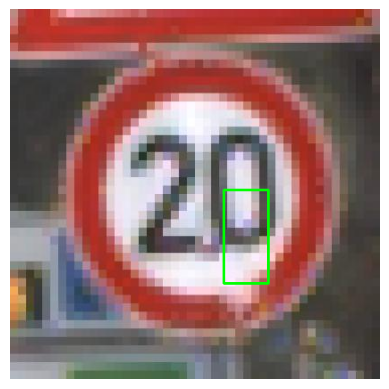

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to predict and visualize bounding box
def predict_and_visualize(model, image_path):
    # Load the original image
    image = cv2.imread(image_path)
    
    # Store the original image shape
    original_height, original_width, _ = image.shape
    print(image.shape)
    # Resize the image to the model input size (224x224)
    image_resized = cv2.resize(image, (224, 224))  # Resize for model input
    image_normalized = image_resized / 255.0  # Normalize the image
    image_expanded = np.expand_dims(image_normalized, axis=0)  # Add batch dimension

    # Make prediction
    predicted_bbox = model.predict(image_expanded)  # Get predicted bounding box
    predicted_bbox = predicted_bbox[0]  # Get the first prediction (batch size = 1)
    
    print(f"Predicted bounding box (normalized): {predicted_bbox}")
    
    # Convert the predicted bounding box from [0,1] range to pixel values
    x_min, y_min, x_max, y_max = predicted_bbox
    
    # Scale the bounding box coordinates to the original image size
    x_min = int(x_min * original_width)
    y_min = int(y_min * original_height)
    x_max = int(x_max * original_width)
    y_max = int(y_max * original_height)
    
    # Ensure bounding box is valid (coordinates within the image dimensions)
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(original_width, x_max)
    y_max = min(original_height, y_max)
    
    print(f"Bounding box coordinates on the original image: ({x_min}, {y_min}), ({x_max}, {y_max})")
    
    # Draw the bounding box on the original image
    image_with_bbox = cv2.rectangle(image.copy(), 
                                    (x_min, y_min), 
                                    (x_max, y_max), 
                                    (0, 255, 0), 2)  # Green bounding box

    # Display the image with the bounding box
    plt.imshow(cv2.cvtColor(image_with_bbox, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.axis('off')  # Hide axis
    plt.show()

# Example: Test the function on a sample image
image_path = '/kaggle/input/cardetection/car/train/images/00000_00000_00016_png.rf.b8f0678f2b179f3b8d50d47b1549b069.jpg'  # Example path
predict_and_visualize(model, image_path)  # Predict and visualize the bounding box


(416, 416, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted bounding box (normalized): [0.5424637  0.3449814  0.23751928 0.3077727 ]
Bounding box coordinates on the original image: (225, 143), (98, 128)


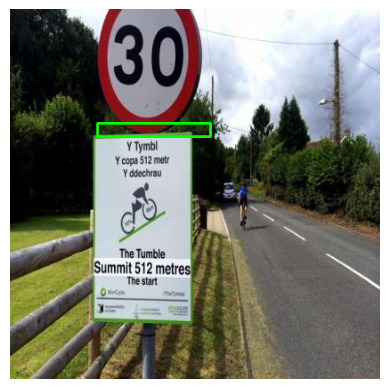

In [18]:
# Example: Test the function on a sample image
image_path = '/kaggle/input/cardetection/car/test/images/000006_jpg.rf.89610ec419ccfab22f8314026b90ee26.jpg'  # Path to the sample image
predict_and_visualize(model, image_path)  # Predict and visualize the bounding box